# Import Stuff

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Load Some Test Images

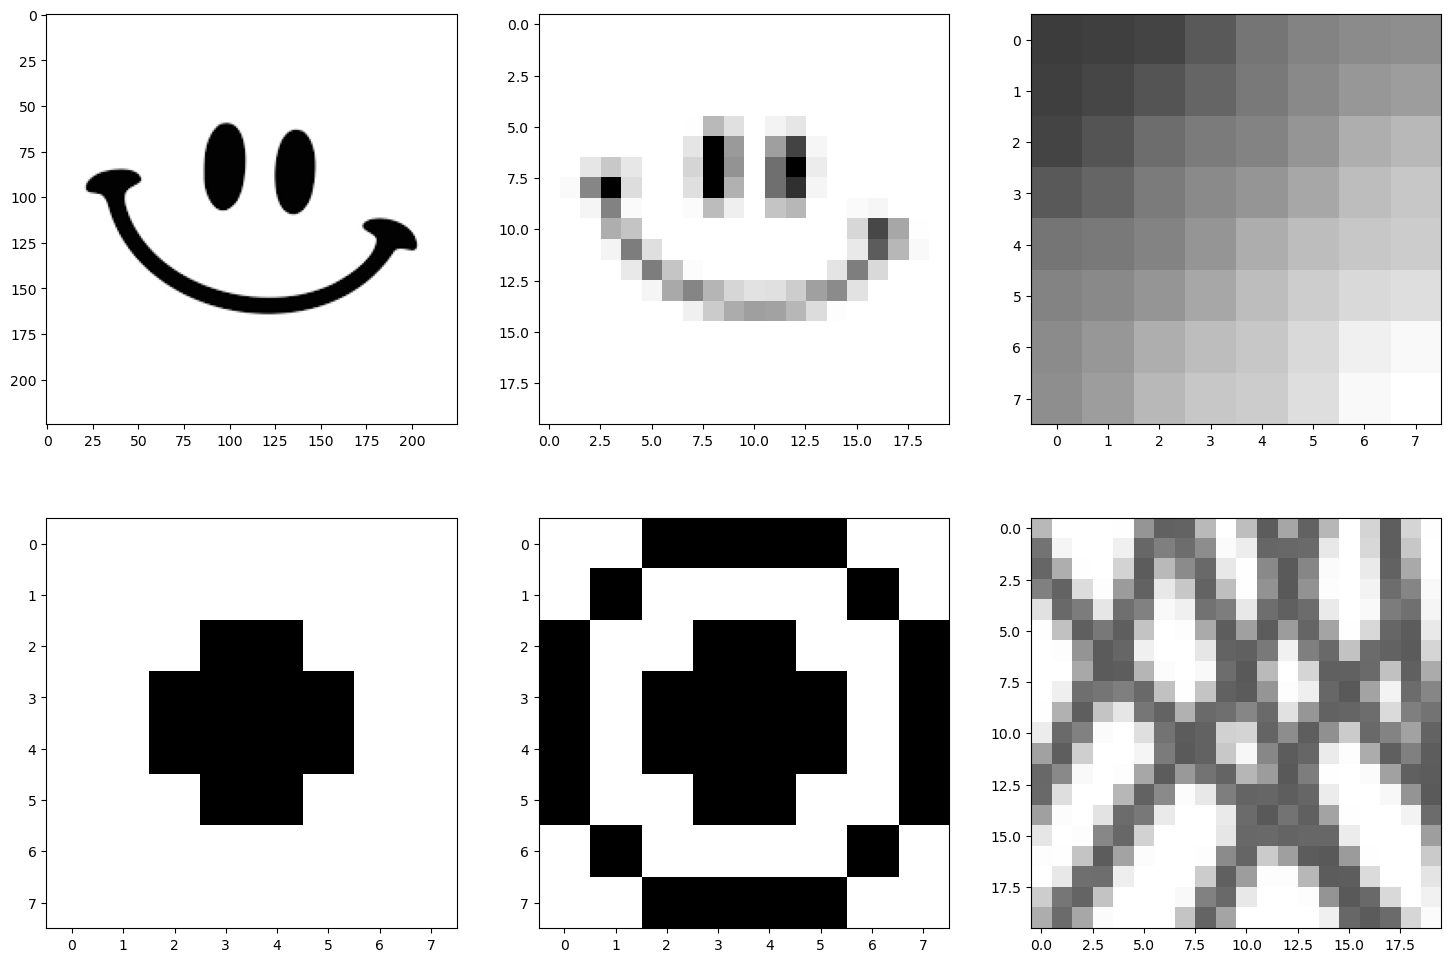

In [3]:
smiley = Image.open("../Pictures/smiley.png").convert("F")
smiley_low = Image.open("../Pictures/smiley_low.png").convert("F")
target = Image.open("../Pictures/target.png").convert("F")
target2 = Image.open("../Pictures/target2.png").convert("F")
gradient = Image.open("../Pictures/gradient.png").convert("F")
hatching = Image.open("../Pictures/hatching.png").convert("F")

fig, axes = plt.subplots(2, 3, figsize=(18,12))
axes[0][0].imshow(smiley)
axes[0][1].imshow(smiley_low)
axes[0][2].imshow(gradient)
axes[1][0].imshow(target)
axes[1][1].imshow(target2)
axes[1][2].imshow(hatching)

plt.show()

# Image Dataset

In [4]:
class ImageDataset(Dataset):
    def __init__(self, img):
        super().__init__()
        self.img = img

        img_size = self.img.width * self.img.height
        
        self.coords = torch.zeros((img_size, 2))
        self.pixels = torch.zeros((img_size, 1))
        
        for idx in range(img_size):
            x_idx = idx % self.img.width
            y_idx = math.trunc(idx / self.img.width)

            value = self.img.getpixel((x_idx, y_idx))

            x_idx = (x_idx / (self.img.width - 1)) * 2.0 - 1.0
            y_idx = (y_idx / (self.img.height - 1)) * 2.0 - 1.0

            value = (value / 255) * 2.0 - 1.0

            self.coords[idx] = torch.tensor([x_idx, y_idx])
            self.pixels[idx] = value

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

# Training Loop

In [5]:
def training_loop(model, num_steps, steps_til_summary, img_shape, optimizer, loss_fn, model_input, ground_truth):    
    for step in range(num_steps):
        model_output = model(model_input)
        loss = loss_fn(model_output, ground_truth)

        if step % steps_til_summary == 0:
            print("Step %d, Total loss %0.6f" % (step, loss.item()))

            model_output_np = model_output.cpu().view(img_shape).detach().numpy()
            ground_truth_np = ground_truth.cpu().view(img_shape).detach().numpy()
        
            img_loss = abs(model_output_np - ground_truth_np)
        
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(ground_truth_np)
            axes[1].imshow(model_output_np)
            axes[2].imshow(img_loss)
            plt.show()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ReLU Stack

In [5]:
class ReLUNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=True):
        super().__init__()

        self.net = []
        self.net.append(torch.nn.Linear(in_features, hidden_features))
        self.net.append(torch.nn.ReLU())

        for idx in range(hidden_layers):
            self.net.append(torch.nn.Linear(hidden_features, hidden_features))
            self.net.append(torch.nn.ReLU())

        self.net.append(torch.nn.Linear(hidden_features, out_features))
        
        if not outermost_linear:
            self.net.append(torch.nn.ReLU())

        self.net = torch.nn.Sequential(*self.net)

    def forward(self, model_input):
        output = self.net(model_input)
        return output

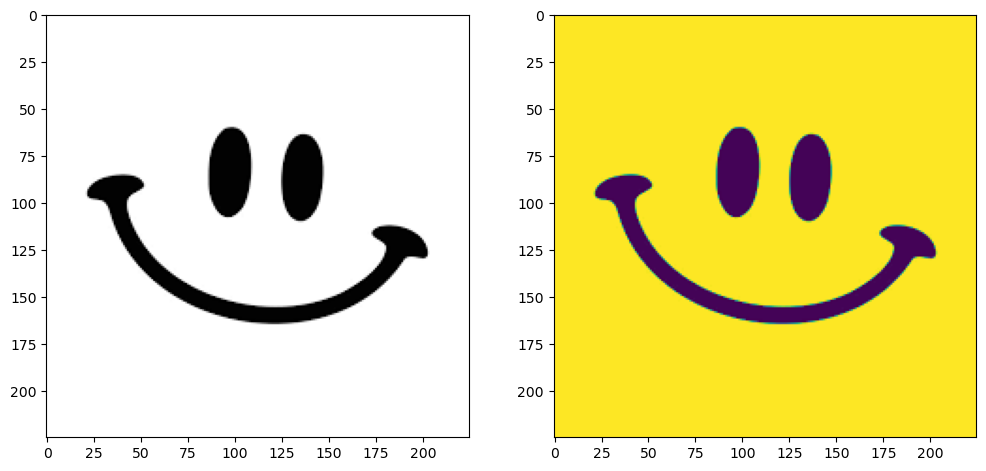

ReLUNetwork(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [9]:
relu_dataset = ImageDataset(smiley)
relu_dataloader = DataLoader(relu_dataset, batch_size=1, pin_memory=True, num_workers=0)

_, ground_truth_temp = next(iter(relu_dataloader))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(relu_dataset.img)
axes[1].imshow(ground_truth_temp.view(relu_dataset.img.width, relu_dataset.img.height).detach().numpy())
plt.show()

img_relu_model = ReLUNetwork(in_features=2, out_features=1, hidden_features=64, hidden_layers=3)

img_relu_model.cuda()

Step 0, Total loss 0.950118


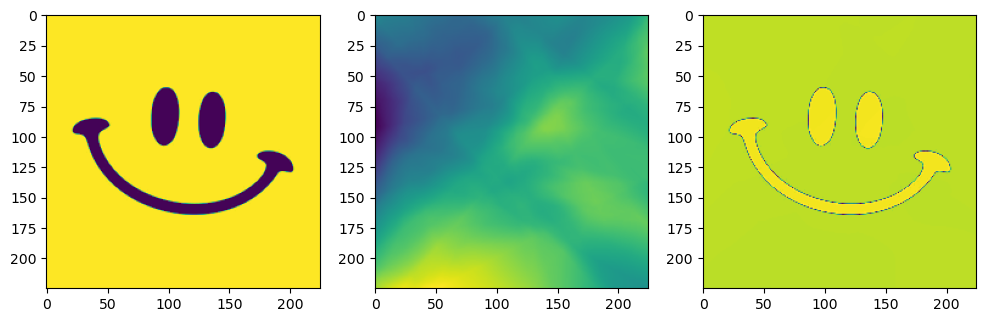

Step 25, Total loss 0.947432


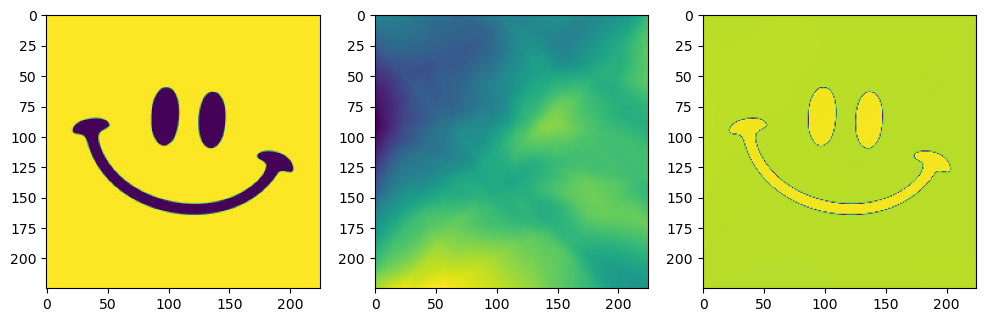

Step 50, Total loss 0.944745


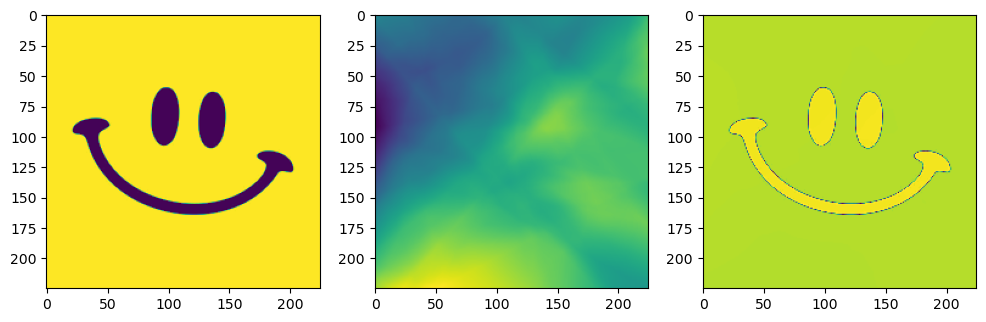

Step 75, Total loss 0.942059


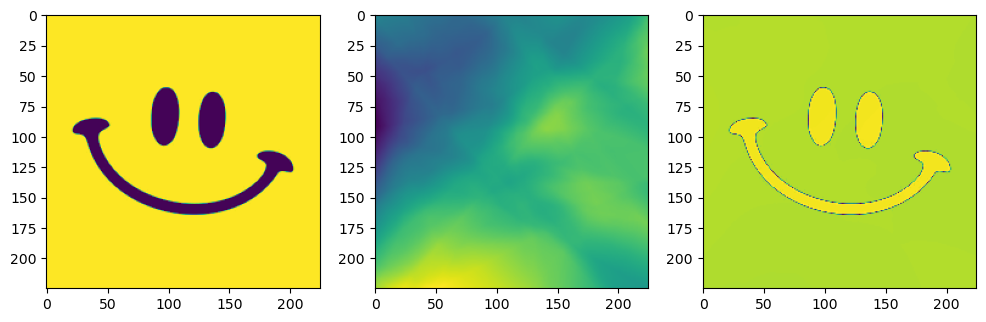

Step 100, Total loss 0.939373


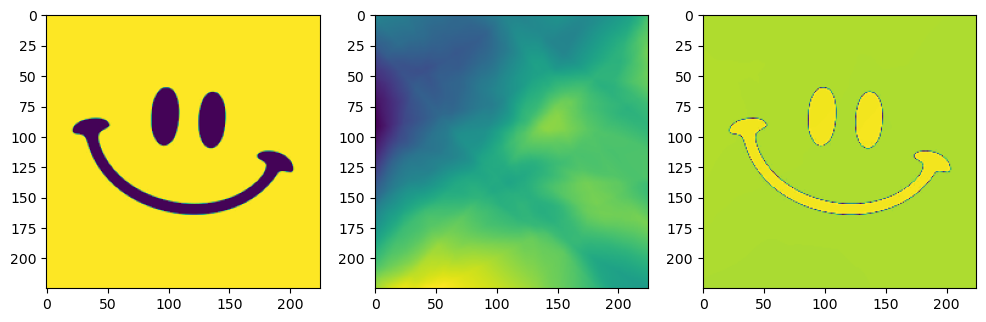

Step 125, Total loss 0.936687


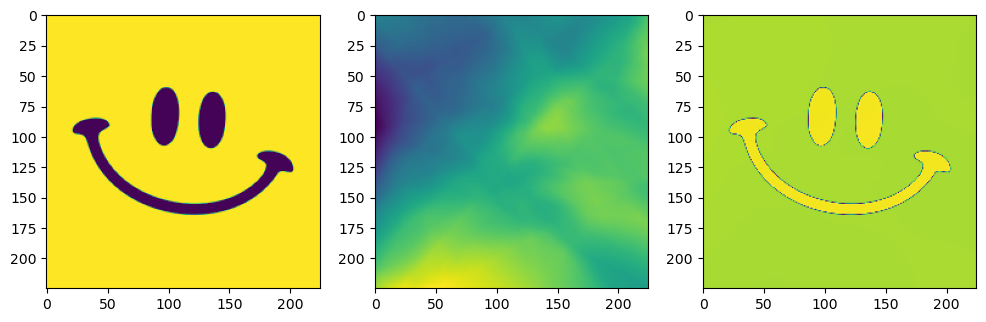

Step 150, Total loss 0.933999


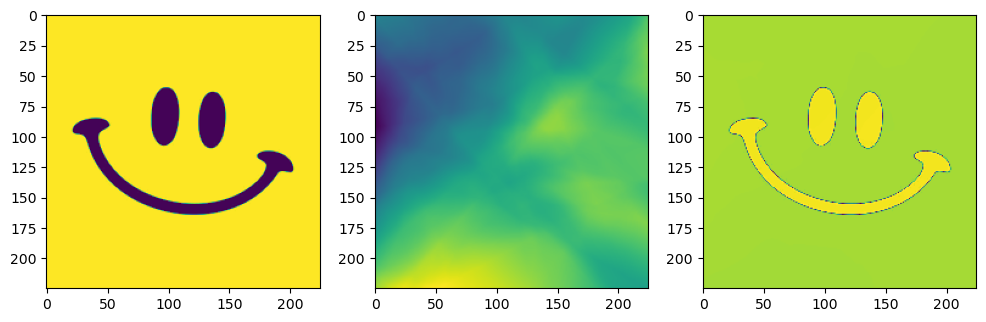

Step 175, Total loss 0.931311


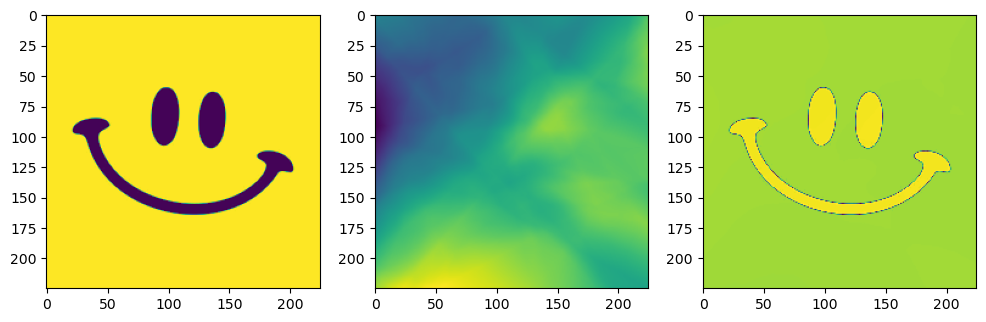

Step 200, Total loss 0.928620


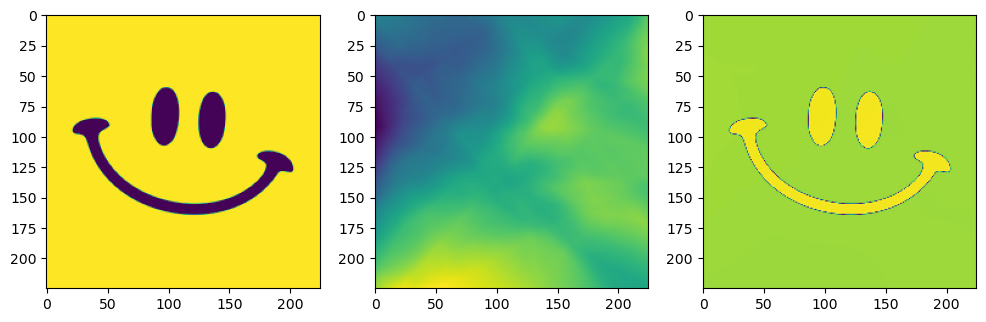

Step 225, Total loss 0.925929


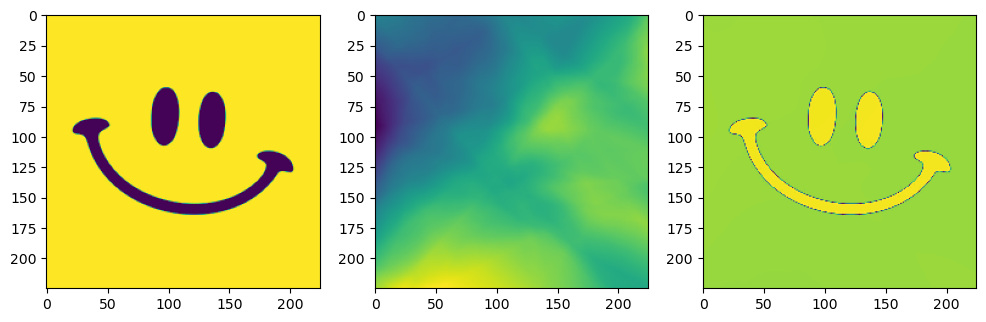

Step 250, Total loss 0.923236


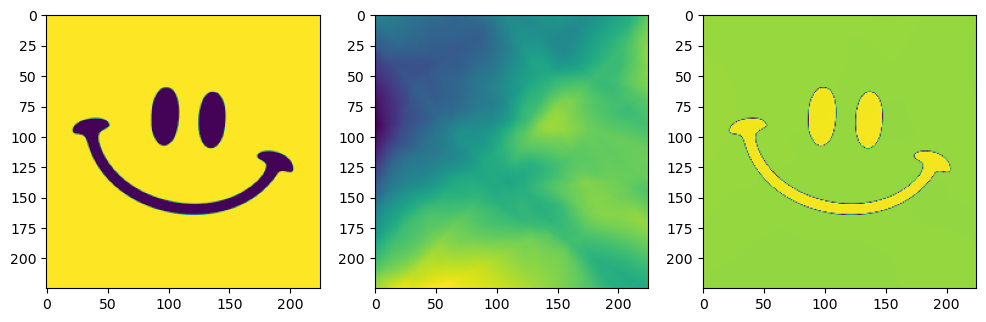

Step 275, Total loss 0.920542


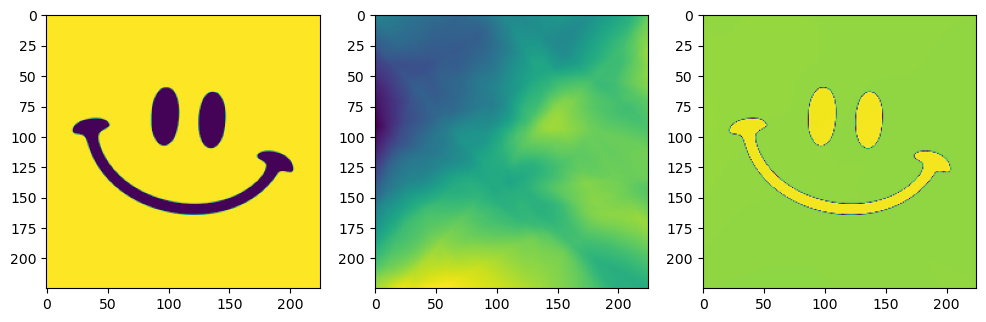

Step 300, Total loss 0.917846


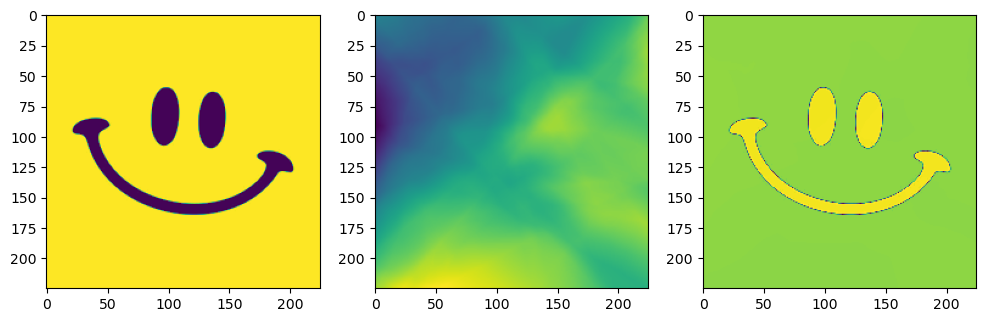

Step 325, Total loss 0.915150


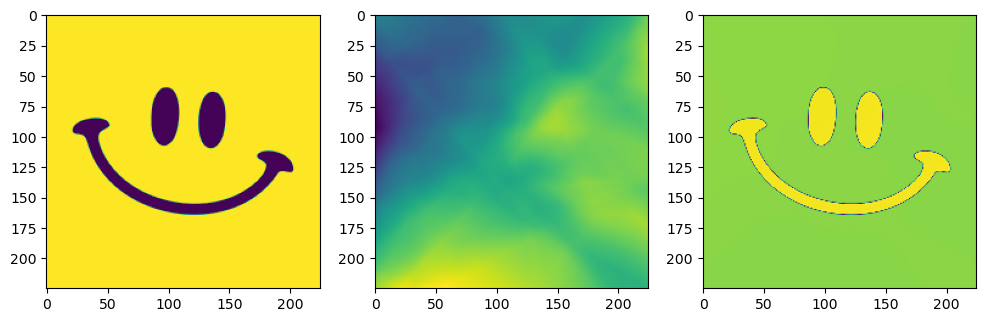

Step 350, Total loss 0.912452


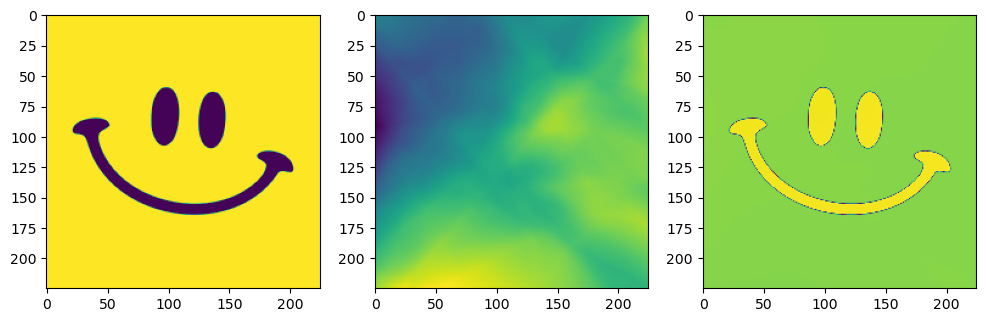

Step 375, Total loss 0.909754


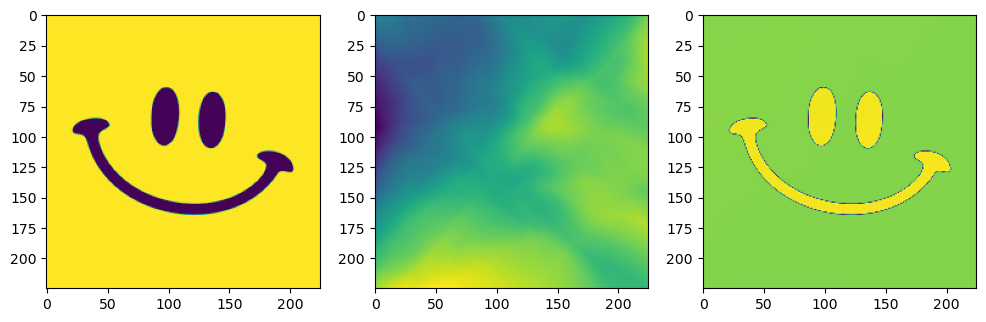

Step 400, Total loss 0.907055


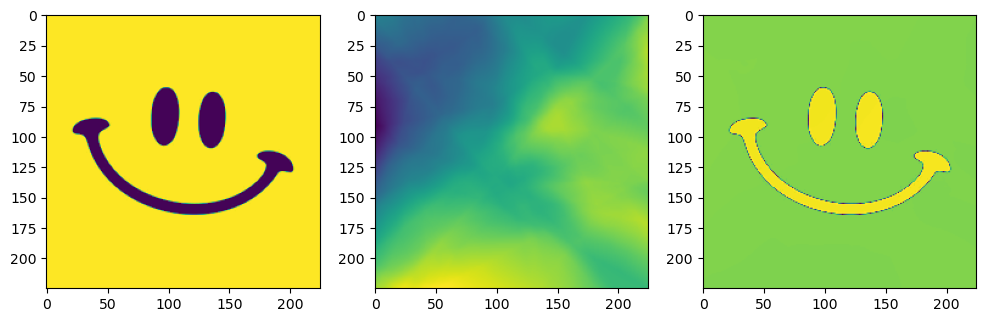

Step 425, Total loss 0.904354


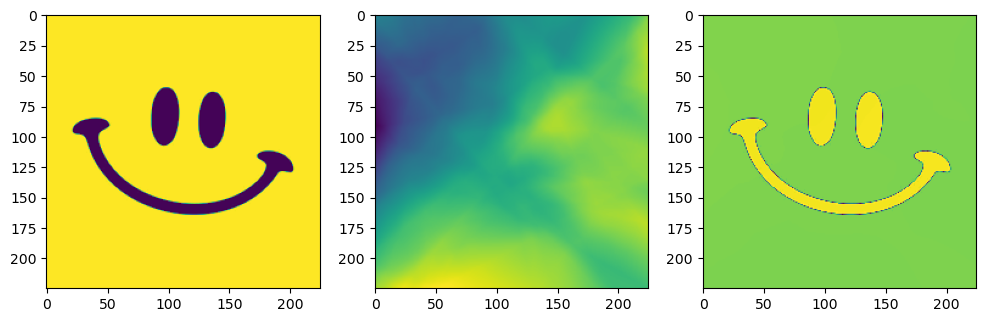

Step 450, Total loss 0.901653


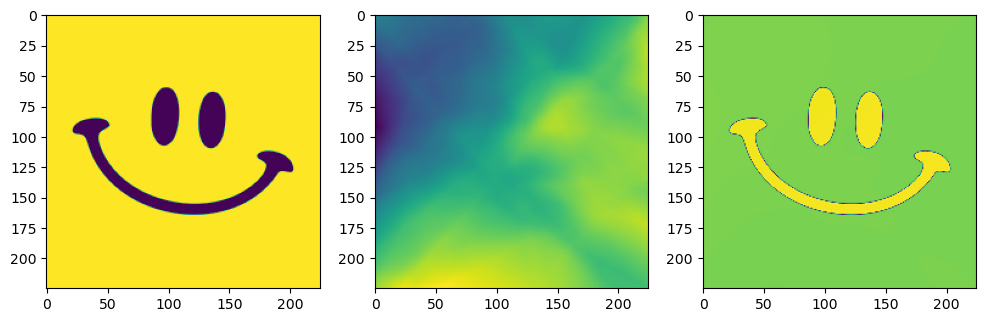

Step 475, Total loss 0.898952


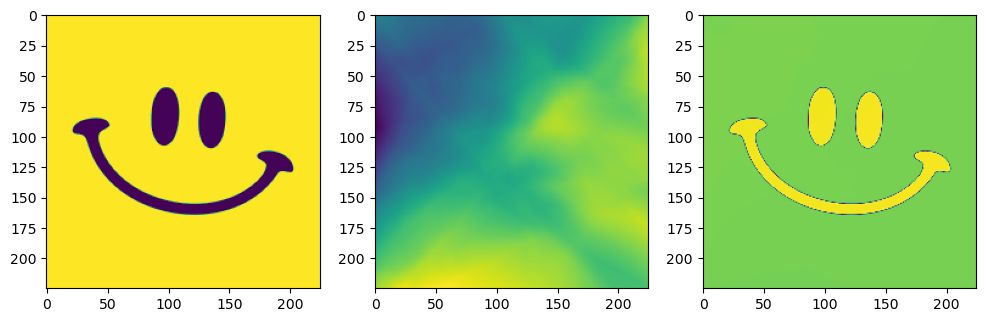

In [10]:
num_steps = 500
steps_til_summary = 25

model = img_relu_model

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

img_shape = (relu_dataset.img.width, relu_dataset.img.height)

model_input, ground_truth = next(iter(relu_dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

training_loop(model, num_steps, steps_til_summary, img_shape, optimizer, loss_fn, model_input, ground_truth)

# Siren Implementation

In [6]:
class SineLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, is_first=False, bias=True, omega_0=30):
        super().__init__()
        self.in_features = in_features
        self.linear = torch.nn.Linear(in_features, out_features, bias=bias)

        self.is_first = is_first
        self.omega_0 = omega_0
    
        self.init_weights()

    def forward(self, model_input):
        return torch.sin(self.omega_0 * self.linear(model_input))

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)

class Siren(torch.nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))

        for idx in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = torch.nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
        
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, omega_0=hidden_omega_0))

        self.net = torch.nn.Sequential(*self.net)

    def forward(self, model_input):
        output = self.net(model_input)
        return output

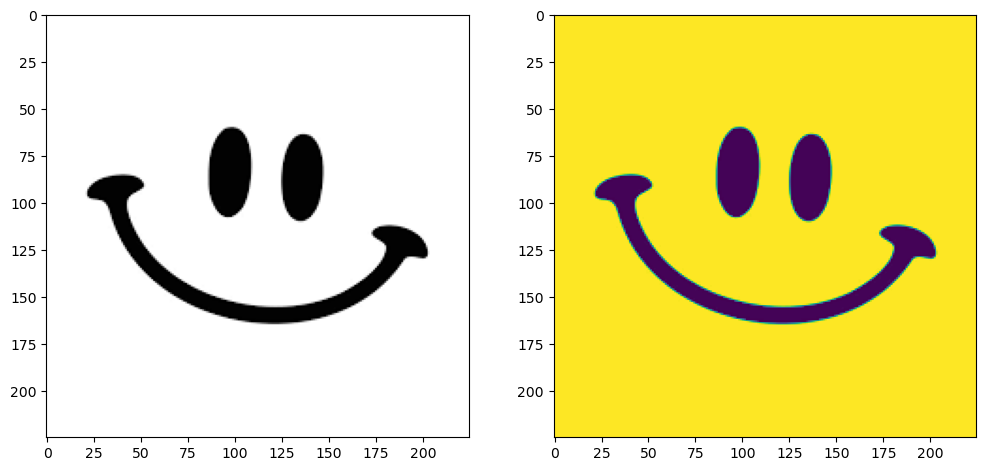

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=64, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [7]:
siren_dataset = ImageDataset(smiley)
siren_dataloader = DataLoader(siren_dataset, batch_size=1, pin_memory=True, num_workers=0)

_, ground_truth_temp = next(iter(siren_dataloader))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(siren_dataset.img)
axes[1].imshow(ground_truth_temp.view(siren_dataset.img.width, siren_dataset.img.height).detach().numpy())
plt.show()

img_siren_model = Siren(in_features=2, out_features=1, hidden_features=64, hidden_layers=3)

img_siren_model.cuda()

Step 0, Total loss 0.005188


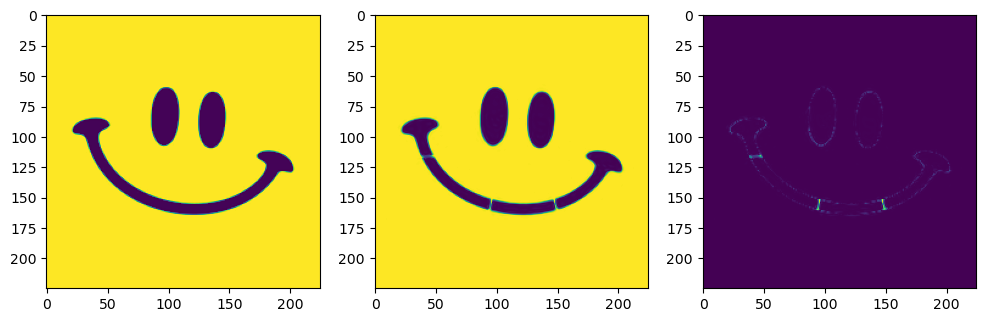

Step 25, Total loss 0.007450


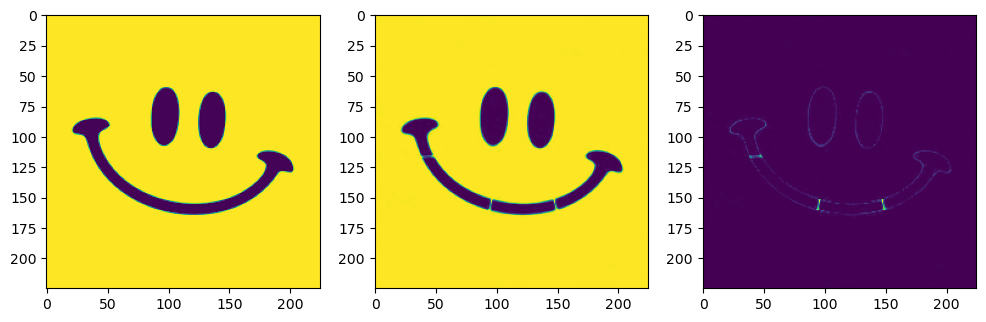

Step 50, Total loss 0.005106


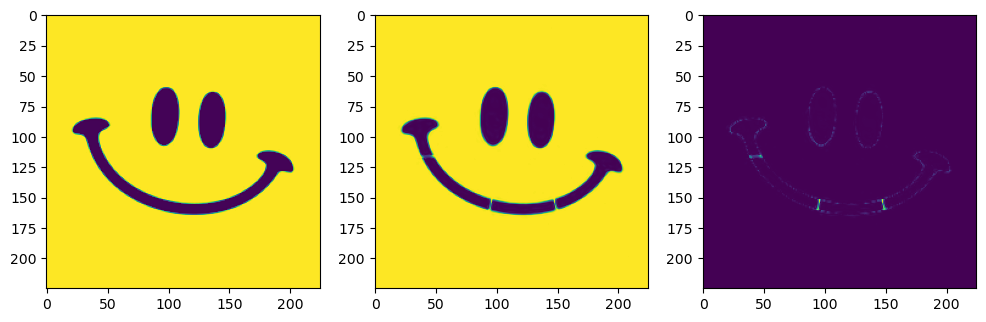

Step 75, Total loss 0.004721


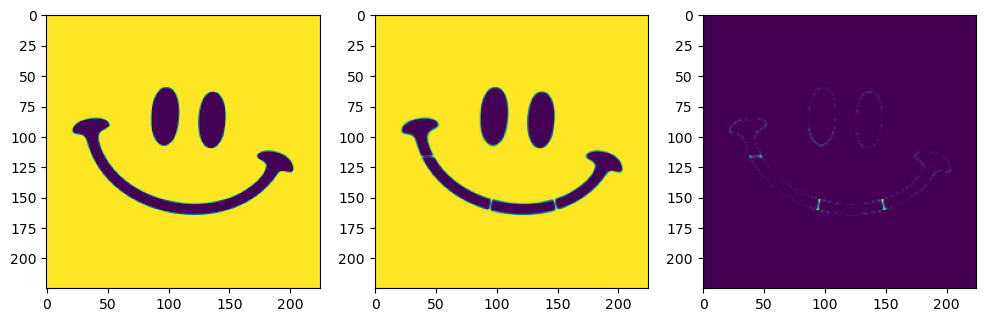

Step 100, Total loss 0.004524


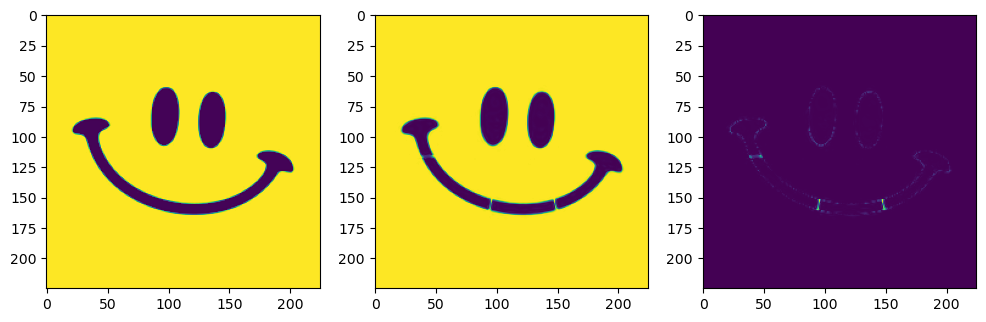

Step 125, Total loss 0.004324


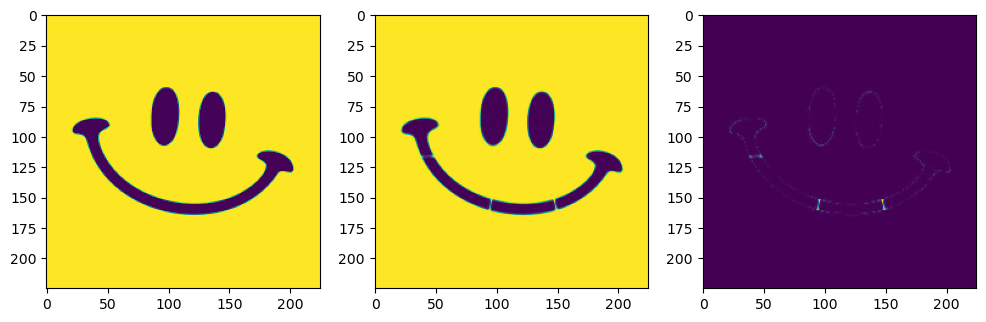

Step 150, Total loss 0.004155


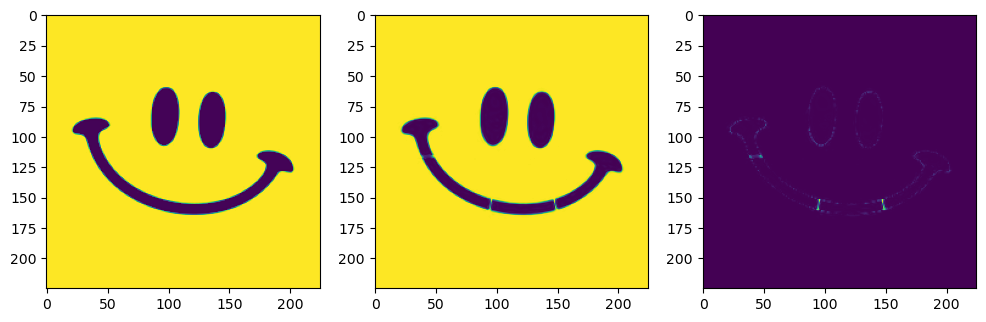

Step 175, Total loss 0.003975


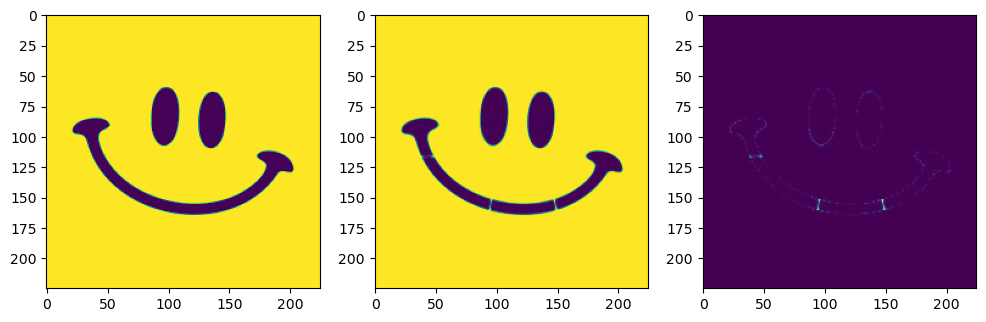

Step 200, Total loss 0.003798


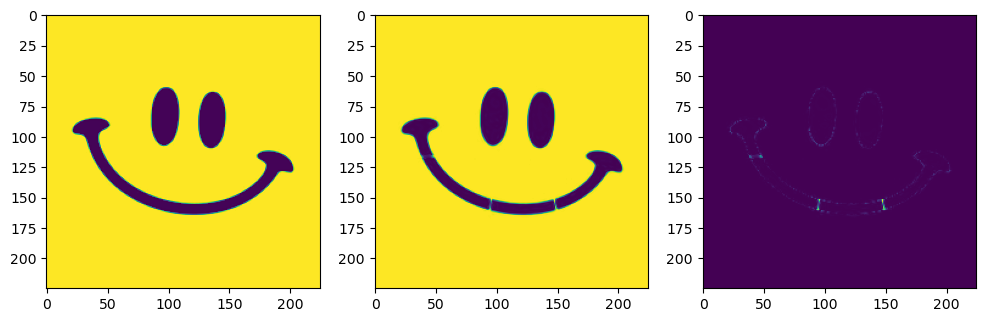

Step 225, Total loss 0.003613


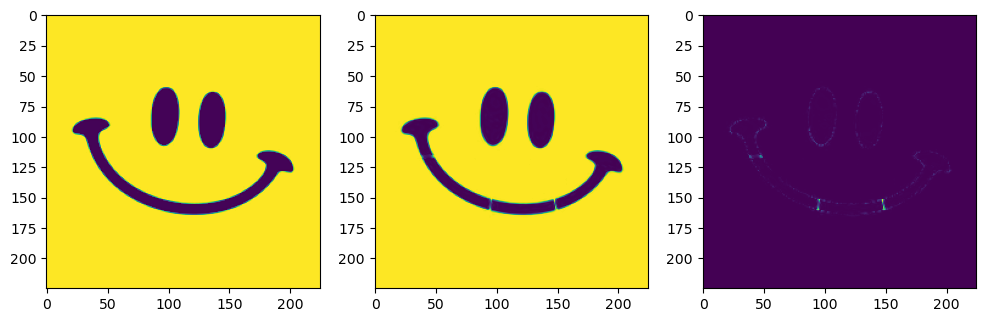

Step 250, Total loss 0.003465


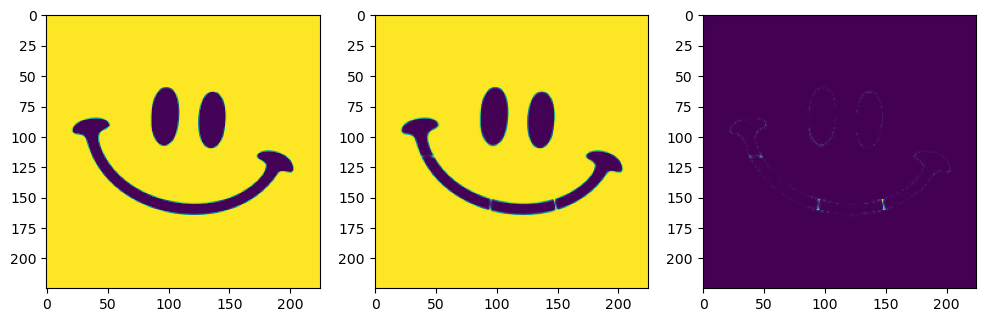

Step 275, Total loss 0.003377


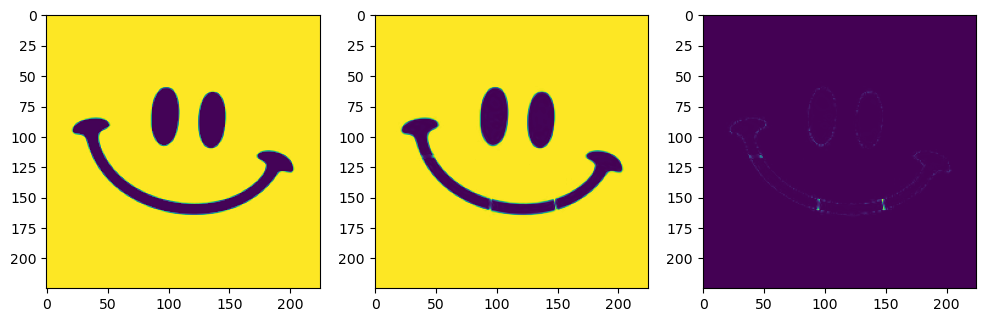

Step 300, Total loss 0.003232


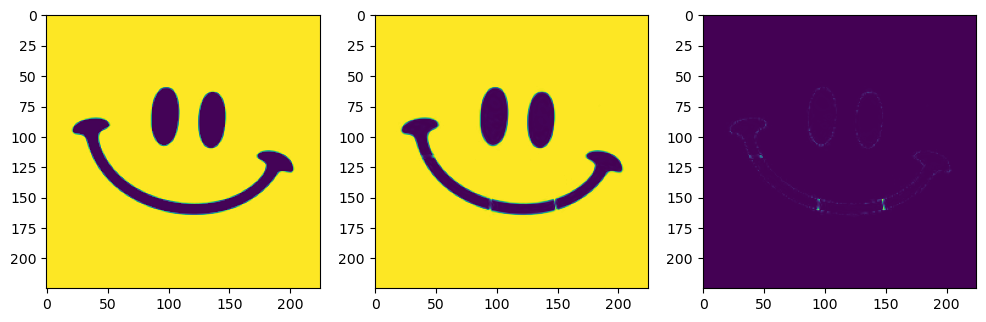

Step 325, Total loss 0.003182


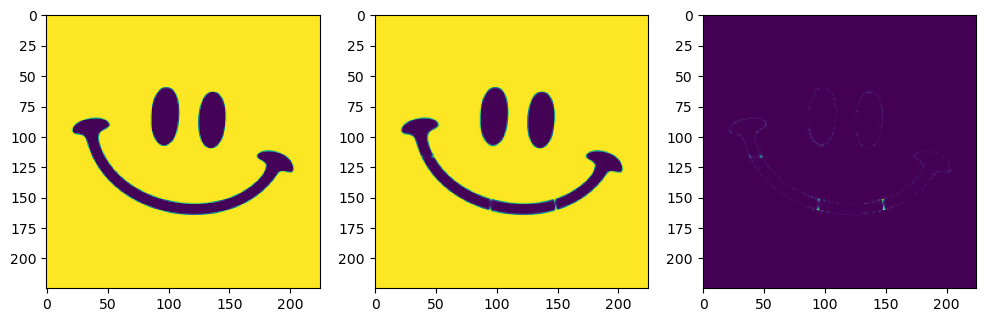

Step 350, Total loss 0.003014


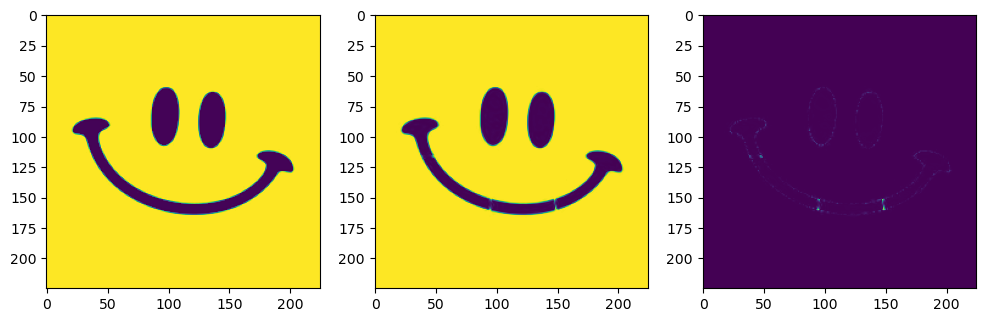

Step 375, Total loss 0.002883


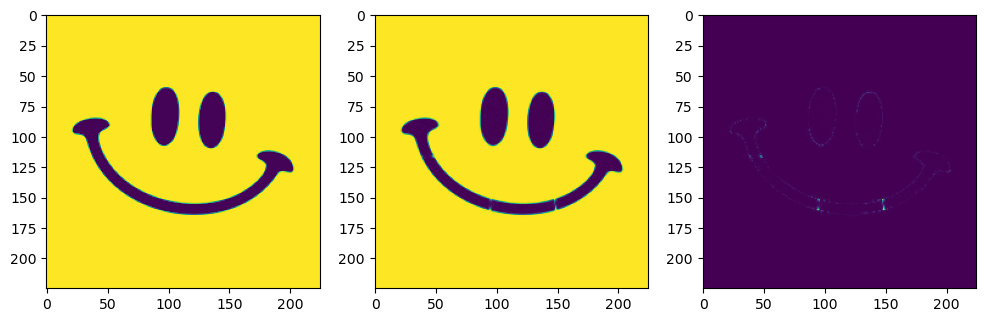

Step 400, Total loss 0.002793


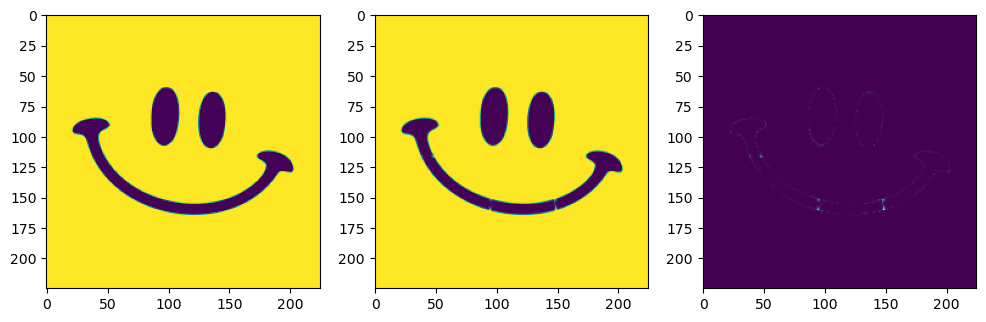

Step 425, Total loss 0.002721


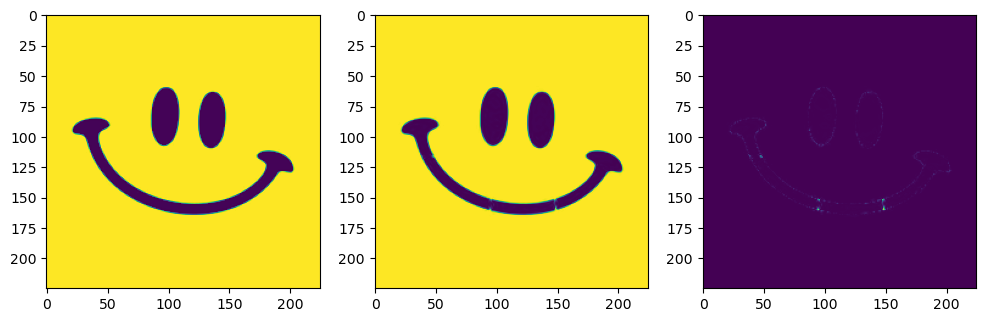

Step 450, Total loss 0.002702


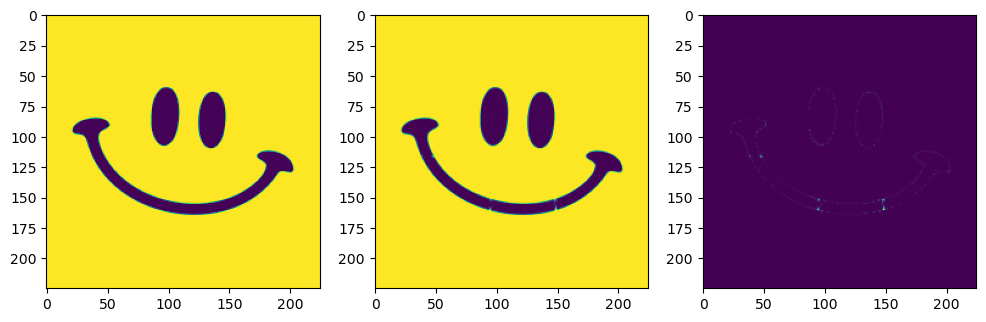

Step 475, Total loss 0.002577


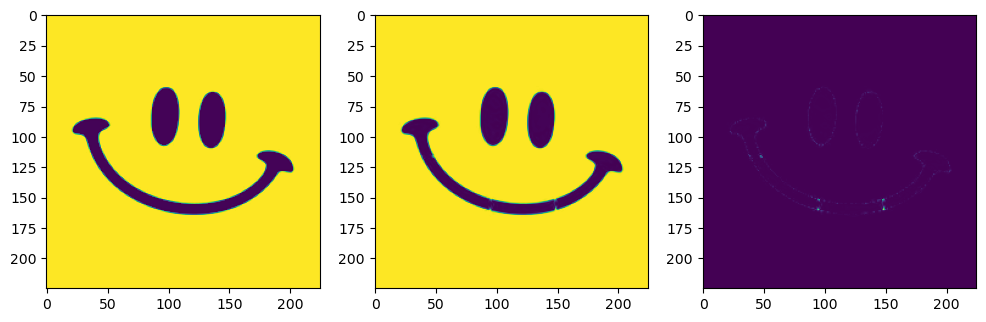

In [9]:
num_steps = 500
steps_til_summary = 25

model = img_siren_model
dataloader = siren_dataloader

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

img_shape = (dataloader.dataset.img.width, dataloader.dataset.img.height)

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

training_loop(model, num_steps, steps_til_summary, img_shape, optimizer, loss_fn, model_input, ground_truth)